In [68]:
import numpy as np
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt

In [69]:
df = pd.read_csv('data/fraud_oracle_processed.csv')

In [70]:
df.head()

,Unnamed: 0,Month,WeekOfMonth,DayOfWeek,Make,AccidentArea,DayOfWeekClaimed,WeekOfMonthClaimed,Sex,Age,...,AddressChange_Claim,NumberOfCars,Year,BasePolicy,MaritalStatus_Married,MaritalStatus_Single,MaritalStatus_Widow,MonthClaimed,UnusualDeductible,ClaimsPerAgent
0,0,Dec,5,Wednesday,Honda,Urban,Tuesday,1,0,21,...,2,3,1994,Liability,False,True,False,1,0,15179
1,1,Jan,3,Wednesday,Honda,Urban,Monday,4,1,34,...,0,1,1994,Collision,False,True,False,1,0,15179
2,2,Oct,5,Friday,Honda,Urban,Thursday,2,1,47,...,0,1,1994,Collision,True,False,False,11,0,15179
3,3,Jun,2,Saturday,Toyota,Rural,Friday,1,1,65,...,0,1,1994,Liability,True,False,False,7,0,15179
4,4,Jan,5,Monday,Honda,Urban,Tuesday,2,0,27,...,0,1,1994,Collision,False,True,False,2,0,15179


## Touch up on data cleaning for Feature Importance Ranking


In [71]:
# Remove index column
df = df.iloc[:, 1:]

In [72]:
# Remove one row with DayOfWeekClaimed = 0 and MonthClaimed = 0
df = df.loc[~((df['DayOfWeekClaimed'] == '0') | (df['MonthClaimed'] == '0'))]

In [73]:
# Reorder the columns such that PolicyNumber is first
cols = df.columns.tolist()         # get the current column order
cols.remove('PolicyNumber')         # remove 'PolicyNumber' from its current position
df = df[['PolicyNumber'] + cols]     # reassemble the DataFrame with 'PolicyNumber' as the first column
print("Columns:")
for col in cols:
    print(f"• {col}")   #list of labels

Columns:
• Month
• WeekOfMonth
• DayOfWeek
• Make
• AccidentArea
• DayOfWeekClaimed
• WeekOfMonthClaimed
• Sex
• Age
• Fault
• PolicyType
• VehicleCategory
• VehiclePrice
• FraudFound_P
• RepNumber
• Deductible
• DriverRating
• Days_Policy_Accident
• Days_Policy_Claim
• PastNumberOfClaims
• AgeOfVehicle
• AgeOfPolicyHolder
• PoliceReportFiled
• WitnessPresent
• AgentType
• NumberOfSuppliments
• AddressChange_Claim
• NumberOfCars
• Year
• BasePolicy
• MaritalStatus_Married
• MaritalStatus_Single
• MaritalStatus_Widow
• MonthClaimed
• UnusualDeductible
• ClaimsPerAgent


In [74]:
# Convert dummy variables to a single MaritalStatus column
df['MaritalStatus'] = df.filter(regex = '^MaritalStatus_').idxmax(axis = 1)
df['MaritalStatus'] = df['MaritalStatus'].str.replace('MaritalStatus_', '')
df.drop(['MaritalStatus_Married', 'MaritalStatus_Single', 'MaritalStatus_Widow'], axis = 1, inplace = True)

### Numerical Mapping

In [75]:
# Mappings for numerical df

month_mapping = {
    'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'Jun': 6,
    'Jul': 7, 'Aug': 8, 'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12
}

day_mapping = {
    'Monday': 1, 'Tuesday': 2, 'Wednesday': 3, 'Thursday': 4, 'Friday': 5, 'Saturday': 6, 'Sunday': 7
}

area_mapping = {
    'Rural': 0, 'Urban': 1
}

fault_mapping = {
    'Policy Holder': 0, 'Third Party': 1
}

vtype_mapping = {
    'Sedan': 1, 'Sport': 2, 'Utility': 3
}

basepol_mapping = {
    'Collision': 1, 'Liability': 2, 'All Perils': 3
}

ptype_mapping = {}
for vtype, v_val in vtype_mapping.items():
    for basepol, bp_val in basepol_mapping.items():
        key = f'{vtype} - {basepol}'
        ptype_mapping[key] = v_val * 10 + bp_val

mstatus_mapping = {
    'Single': 0, 'Married': 1, 'Widow': 2
}

extra_mappings = {
    'Month': month_mapping,
    'DayOfWeek': day_mapping,
    'DayOfWeekClaimed': day_mapping,
    'AccidentArea': area_mapping,
    'Fault': fault_mapping,
    'VehicleCategory': vtype_mapping,
    'BasePolicy': basepol_mapping,
    'PolicyType': ptype_mapping,
    'MaritalStatus': mstatus_mapping
}

In [76]:
# Convert categorical variables to numerical in numeric df
numeric_df = df.copy()
for col, mapping in extra_mappings.items():
    numeric_df[col] = numeric_df[col].map(mapping)

#print(numeric_df)

In [77]:
# Remove Make(car brand) column as VehiclePrice provides more/same value as car brand and car brand is categorical
numeric_df.drop(['Make'], axis = 1, inplace = True)

In [78]:
# Reordering columns for easier visualization
cols = numeric_df.columns.tolist()         
cols.remove("MonthClaimed")   
cols.remove("WeekOfMonthClaimed")
idx = cols.index("DayOfWeekClaimed")
cols.insert(idx, "WeekOfMonthClaimed") 
cols.insert(idx, "MonthClaimed") 
numeric_df = numeric_df[cols]

### Days Between Accident and Claim and Claim Processing Time

In [79]:
## Investigation for days_policy_claim and days_policy_accident
# Mapping below for reference
# 'Days_Policy_Accident': {'none': 0, '1 to 7': 1, '8 to 15': 2, '15 to 30': 3, "more than 30": 4}
# 'Days_Policy_Claim': {'none': 0, '8 to 15': 2, '15 to 30': 3, 'more than 30': 4}

# Days_Policy_Accident is the number of days since the policy was issued until the accident occurred. 
# Days Policy_CLaim is the number of day since the policy was issued until the claim was made.
numeric_df[['Days_Policy_Claim', 'Days_Policy_Accident', 'FraudFound_P']].value_counts()

Days_Policy_Claim  Days_Policy_Accident  FraudFound_P
4                  4                     0               14339
                                         1                 904
                   0                     0                  31
                   3                     0                  31
                   2                     0                  20
3                  2                     0                  17
                   3                     0                  15
2                  2                     0                  13
3                  0                     0                  10
4                  1                     0                   7
3                  1                     0                   6
4                  0                     1                   6
2                  0                     0                   5
3                  2                     1                   3
2                  0                     1                   2
4

In [80]:
numeric_df[numeric_df['Days_Policy_Claim'] < numeric_df['Days_Policy_Accident']].iloc[:, [0, 1, 2, 3, 5, 6, 7, 14, 18, 19]]
#we can see there are 3 policies where days_policy_claim < days_policy_accident (claim happened before accident which is not plausible) what do we do with these 3 rows?

,PolicyNumber,Month,WeekOfMonth,DayOfWeek,MonthClaimed,WeekOfMonthClaimed,DayOfWeekClaimed,FraudFound_P,Days_Policy_Accident,Days_Policy_Claim
7223,7224,5,1,2,5,1,5,0,4,3
13447,13448,7,2,1,7,2,3,1,4,3
13830,13831,3,2,2,3,2,2,0,4,3


In [81]:
# Replace all 0 in Days_Policy_Accident to 1 as the categories none and '1 to 7' should be grouped together when calculating DaysBetween
numeric_df['Days_Policy_Accident'] = numeric_df['Days_Policy_Accident'].replace(0, 1)

# Create a column called DaysBetween to get the number of days between accident and claim 
numeric_df['DaysBetween'] = numeric_df['Days_Policy_Claim'] - numeric_df['Days_Policy_Accident'] + 1
numeric_df['DaysBetween'].unique()
# 'DaysBetween: {'less than 0 (weird)': 0, '0 to 7': 1, '8 to 15': 2, '16-30': 3, 'More than 30': 4}'

array([1, 2, 4, 3, 0], dtype=int64)

In [82]:
# Create a column called ClaimProcessingTime to get the number of days between claim made and processed
# Compute a rough day-of-year approximation for accident and claim dates.
numeric_df['claim_day'] = (numeric_df['Month'] - 1) * 30 + (numeric_df['WeekOfMonth'] - 1) * 7 + numeric_df['DayOfWeek']
numeric_df['processed_day'] = (numeric_df['MonthClaimed'] - 1) * 30 + (numeric_df['WeekOfMonthClaimed'] - 1) * 7 + numeric_df['DayOfWeekClaimed']
numeric_df['ClaimProcessingTime'] = numeric_df['processed_day'] - numeric_df['claim_day'] 
numeric_df['ClaimProcessingTime'] = numeric_df['ClaimProcessingTime'] + 365
numeric_df.drop(['claim_day', 'processed_day'], axis = 1, inplace = True)

print(numeric_df['ClaimProcessingTime'])
numeric_df[numeric_df['ClaimProcessingTime'] > 0]

0          6
1        370
2        373
3        387
4        375
        ... 
15415    369
15416    368
15417    368
15418    375
15419    373
Name: ClaimProcessingTime, Length: 15419, dtype: int64


,PolicyNumber,Month,WeekOfMonth,DayOfWeek,AccidentArea,MonthClaimed,WeekOfMonthClaimed,DayOfWeekClaimed,Sex,Age,...,NumberOfSuppliments,AddressChange_Claim,NumberOfCars,Year,BasePolicy,UnusualDeductible,ClaimsPerAgent,MaritalStatus,DaysBetween,ClaimProcessingTime
0,1,12,5,3,1,1,1,2,0,21,...,0,2,3,1994,2,0,15179,0,1,6
1,2,1,3,3,1,1,4,1,1,34,...,0,0,1,1994,1,0,15179,0,1,370
2,3,10,5,5,1,11,2,4,1,47,...,0,0,1,1994,1,0,15179,1,1,373
3,4,6,2,6,0,7,1,5,1,65,...,5,0,1,1994,2,0,15179,1,1,387
4,5,1,5,1,1,2,2,2,0,27,...,0,0,1,1994,1,0,15179,0,1,375
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15415,15416,11,4,5,1,11,5,2,1,35,...,0,0,1,1996,1,0,15179,1,1,369
15416,15417,11,5,4,1,12,1,5,1,30,...,5,0,3,1996,2,0,15179,1,1,368
15417,15418,11,5,4,0,12,1,5,1,24,...,1,0,1,1996,1,0,15179,0,1,368
15418,15419,12,1,1,1,12,2,4,0,34,...,5,0,1,1996,3,0,15179,1,1,375


From our exploration of the data, we realise that the max difference in claim made date and claim processed date is 363, so we add 365 days to remove all the negative data. BIG ASSUMPTION

In [83]:
min_negative_value = numeric_df['DaysBetween'][numeric_df['DaysBetween'] < 0].min()
print(min_negative_value)

nan


In [84]:
# Now all values are numeric and ready for Feature Importance Modelling
all_numeric = all(np.issubdtype(dtype, np.number) for dtype in numeric_df.dtypes)
print(all_numeric)

True


### Cleaning of data with Age = 0

In [85]:
import lightgbm as lgb

# use a LightGBM regression model to predict a reasonable Age value for those rows.
age_outliers = (numeric_df['Age'] == 0)
train_df_age = numeric_df[~age_outliers].copy()
X_train_age = train_df_age.drop(columns = ['Age'])
y_train_age = train_df_age['Age']
lgb_train = lgb.Dataset(X_train_age, label = y_train_age)

params = {
    'objective': 'regression',
    'metric': 'rmse',
    'verbosity': -1,
    'seed': 123
}

gbm = lgb.train(params, lgb_train, num_boost_round=100)
X_outliers_age = numeric_df.loc[age_outliers].drop(columns=['Age'])
numeric_df.loc[age_outliers, 'Age'] = np.rint(gbm.predict(X_outliers_age)).astype(int)

C:\Users\teomi\AppData\Local\Temp\ipykernel_11368\2355481326.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='FraudFound_P', y='Age', data=numeric_df, palette='Set2')


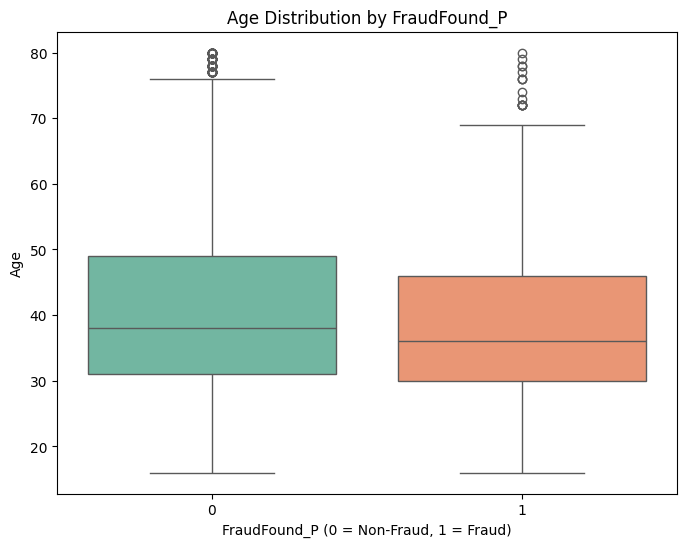

In [105]:
# Distribution of Modified Age
plt.figure(figsize=(8,6))
sns.boxplot(x='FraudFound_P', y='Age', data=numeric_df, palette='Set2')
plt.title('Age Distribution by FraudFound_P')
plt.xlabel('FraudFound_P (0 = Non-Fraud, 1 = Fraud)')
plt.ylabel('Age')
plt.show()

## Overview of value counts

In [86]:
for col in numeric_df.columns:
    print(f"Value counts for {col}:")
    print(numeric_df[col].value_counts())
    print("\n")

Value counts for PolicyNumber:
PolicyNumber
1        1
10361    1
10273    1
10274    1
10275    1
        ..
5146     1
5147     1
5148     1
5149     1
15420    1
Name: count, Length: 15419, dtype: int64


Value counts for Month:
Month
1     1411
5     1367
3     1360
6     1321
10    1305
12    1285
4     1280
2     1266
7     1256
9     1240
11    1201
8     1127
Name: count, dtype: int64


Value counts for WeekOfMonth:
WeekOfMonth
3    3640
2    3557
4    3398
1    3187
5    1637
Name: count, dtype: int64


Value counts for DayOfWeek:
DayOfWeek
1    2615
5    2445
2    2300
4    2173
3    2159
6    1982
7    1745
Name: count, dtype: int64


Value counts for AccidentArea:
AccidentArea
1    13822
0     1597
Name: count, dtype: int64


Value counts for MonthClaimed:
MonthClaimed
1     1446
5     1411
3     1348
10    1339
6     1293
2     1287
11    1285
4     1271
9     1242
7     1225
12    1146
8     1126
Name: count, dtype: int64


Value counts for WeekOfMonthClaimed:
WeekOfMonth

## Variables correlation heatmap

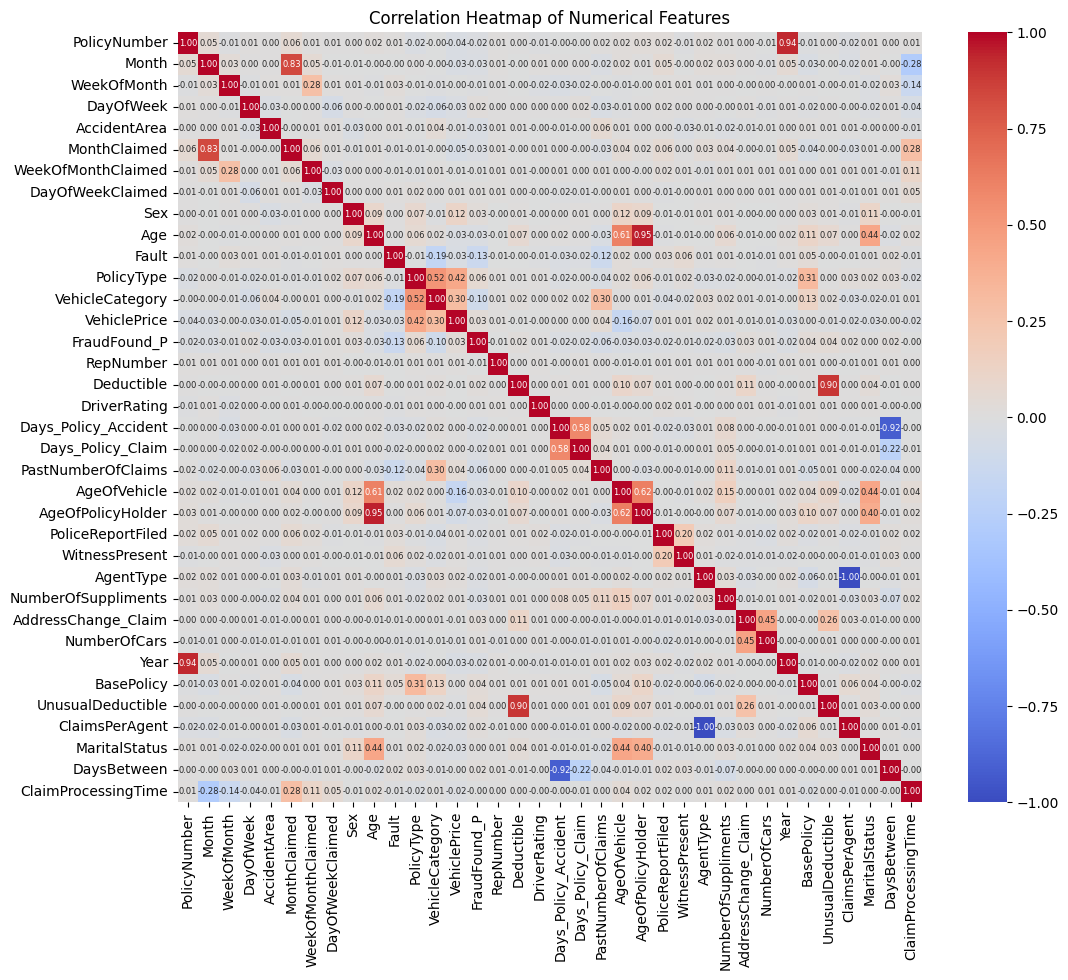

In [87]:
# Correlation heatmap
corr = numeric_df.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f",annot_kws={"size": 6})
plt.title('Correlation Heatmap of Numerical Features')
plt.show()

# **Issue: Curse of Dimensionality**

The "curse of dimensionality" refers to the challenges that arise when working with high-dimensional data such as increased computational complexity and difficulty in visualization and interpretation.

Since our features contain both categorical and numerical data, we have applied several techniques to make the data more compatible. For numerical data which are far apart, we will normalize the data to ensure that they have similar ranges. For categorical data, we use label encoding to encode the categorical data into numerical values.

Hence, by ploting a histogram we can determine if our data is currently facing issue by examining the shape and the standard deviation of the plot.


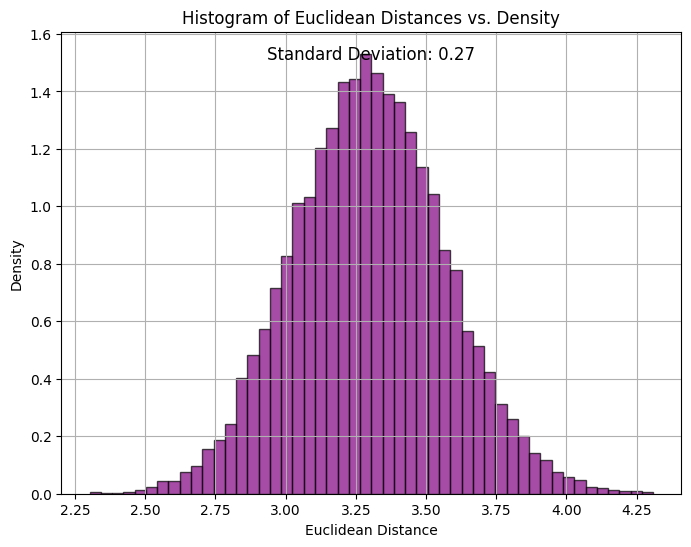

In [88]:
from sklearn.preprocessing import MinMaxScaler

# Drop the columns you don't need
X = numeric_df.drop(['FraudFound_P', 'PolicyNumber'], axis=1)

# Normalize the data (scaling between 0 and 1)
scaler = MinMaxScaler()
X_normalized = scaler.fit_transform(X)

# Compute Euclidean distances between samples and origin
distances = np.linalg.norm(X_normalized, axis=1)

# Calculate standard deviation of Euclidean distances
std_dev = np.std(distances)

# Plot histogram with density
plt.figure(figsize=(8, 6))
plt.hist(distances, bins=50, density=True, edgecolor='black', alpha=0.7, color='purple')
plt.title('Histogram of Euclidean Distances vs. Density')
plt.xlabel('Euclidean Distance')
plt.ylabel('Density')
plt.grid(True)

# Add standard deviation to the plot
plt.text(0.5, 0.95, f'Standard Deviation: {std_dev:.2f}', horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes, fontsize=12)

plt.show()


The plot suggests a normally distributed curve with a rounded peak and an acceptable level of standard deviation. Thus, it appears that the features excluding FraudFound_P does not exhibit the **'Curse of Dimensionality.'** Nonetheless, we intend to proceed with feature selection as we suspect the presence of some meaningless or redundant features in the dataset.

# **Identifying Significant Variables**

For our feature selection, we use **Random Forest**, **XGBoost**, **Logistic Regression** and **Ridge (L2) Regularization**

> Aim:

 1. `Improve Model performance by reducing the risk of overfitting`
 2. `Increase training speed by reducing computational costs`
 3. `Remove redundant features that are not meaningful to us`
 4. `Simplify our model to enhance model interpretibility`


 Note: We will be implementing 4 different types of models to extract the importance scores of each variable, and find out the mean rank score of each variable to select the top 10 most important feature


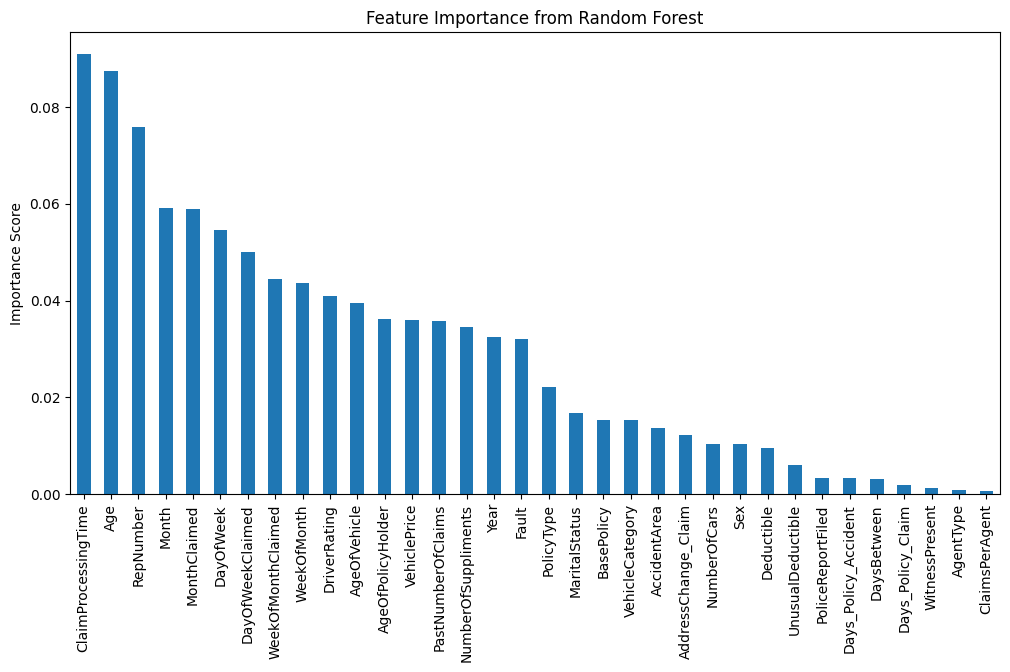

Top 5 Feature Importance Scores: 
ClaimProcessingTime    0.090918
Age                    0.087551
RepNumber              0.075961
Month                  0.059089
MonthClaimed           0.058976
dtype: float64


In [89]:
## Model 1: Random forest Classifier

from sklearn.ensemble import RandomForestClassifier

X = numeric_df.drop(['FraudFound_P', 'PolicyNumber'], axis=1)
y = numeric_df['FraudFound_P']

rf = RandomForestClassifier(random_state=123)
rf.fit(X, y)
importance_rf = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(12, 6))
importance_rf.plot(kind='bar')
plt.title("Feature Importance from Random Forest")
plt.ylabel("Importance Score")
plt.show()
print(f"Top 5 Feature Importance Scores: \n{importance_rf.head(5)}")

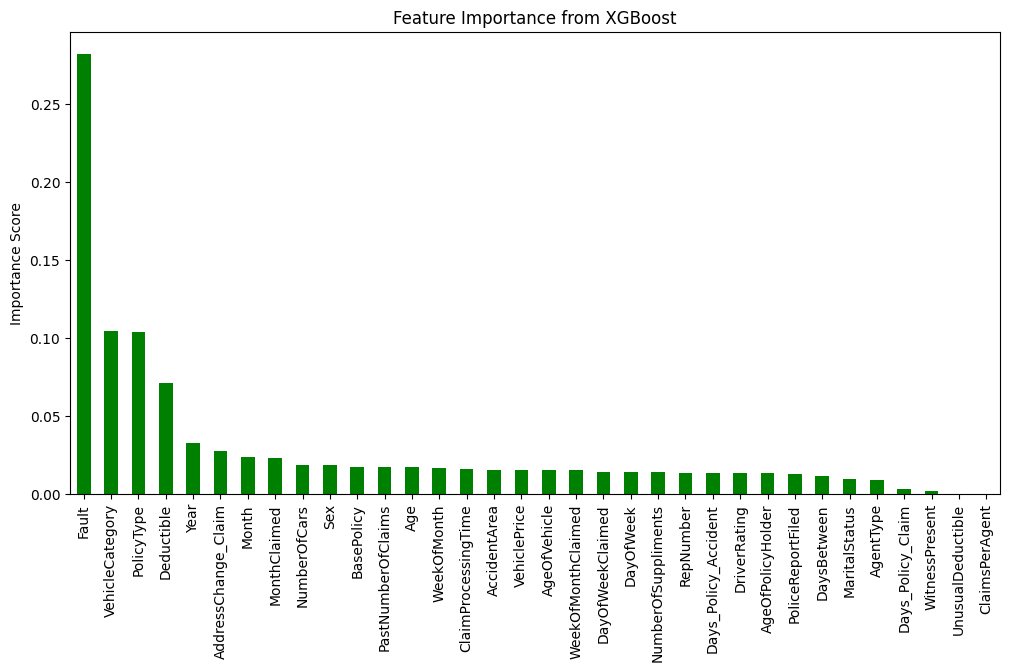

Top 5 Feature Importance Scores: 
Fault              0.281904
VehicleCategory    0.104670
PolicyType         0.103736
Deductible         0.071253
Year               0.033109
dtype: float32


In [90]:
## Model 2: XGBoost

import xgboost as xgb
import pandas as pd
import matplotlib.pyplot as plt

# Prepare the data
X = numeric_df.drop(['FraudFound_P', 'PolicyNumber'], axis=1)
y = numeric_df['FraudFound_P']

# Train the XGBoost model
model = xgb.XGBClassifier(random_state=123)
model.fit(X, y)

# Get feature importance
importance_xgb = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)

# Plot the feature importance scores
plt.figure(figsize=(12, 6))
importance_xgb.plot(kind='bar', color='green')
plt.title("Feature Importance from XGBoost")
plt.ylabel("Importance Score")
plt.show()

print(f"Top 5 Feature Importance Scores: \n{importance_xgb.head(5)}")



C:\Users\teomi\penv\lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


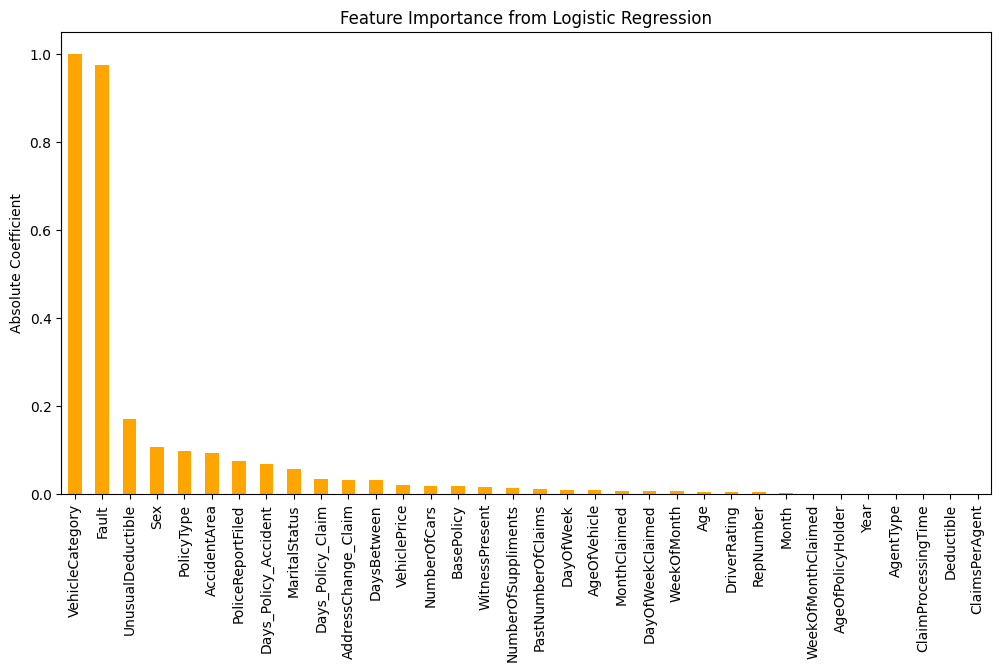

Top 5 Feature Importance Scores: 
VehicleCategory      1.000000
Fault                0.976179
UnusualDeductible    0.171385
Sex                  0.107077
PolicyType           0.098764
dtype: float64


In [91]:
## Model 3: Logistic Regression

from sklearn.linear_model import LogisticRegression

X = numeric_df.drop(['FraudFound_P', 'PolicyNumber'], axis=1)
y = numeric_df['FraudFound_P']

lr = LogisticRegression(random_state=123, max_iter=5000)
lr.fit(X, y)
# Use absolute coefficients because the sign is not as important as the magnitude.
# Use normalized coefficients for better comparison with other models
importance_lr = pd.Series((np.abs(lr.coef_[0]) / np.abs(lr.coef_[0]).max()), index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(12,6))
importance_lr.plot(kind='bar', color='orange')
plt.title("Feature Importance from Logistic Regression")
plt.ylabel("Absolute Coefficient")
plt.show()

print(f"Top 5 Feature Importance Scores: \n{importance_lr.head(5)}")

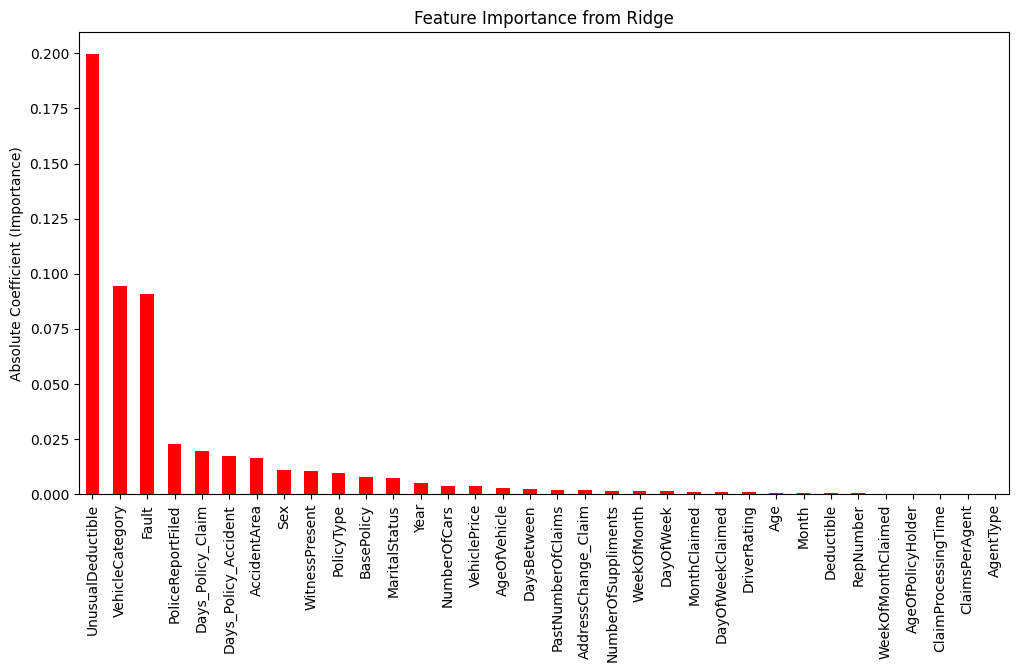

Top 5 Feature Importance Scores: 
UnusualDeductible    0.199574
VehicleCategory      0.094288
Fault                0.090698
PoliceReportFiled    0.022703
Days_Policy_Claim    0.019590
dtype: float64


In [92]:
## Model 4: Ridge Regression (L2 regularization)

from sklearn.linear_model import Ridge

X = numeric_df.drop(['FraudFound_P', 'PolicyNumber'], axis=1)
y = numeric_df['FraudFound_P']

ridge = Ridge(random_state=123)
ridge.fit(X, y)

importance_l2 = pd.Series(np.abs(ridge.coef_), index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(12, 6))
importance_l2.plot(kind='bar', color='red')
plt.title("Feature Importance from Ridge")
plt.ylabel("Absolute Coefficient (Importance)")
plt.show()

print(f"Top 5 Feature Importance Scores: \n{importance_l2.head(5)}")

In [93]:
ranks_rf = importance_rf.rank(ascending=False)
ranks_xgb = importance_xgb.rank(ascending=False)
ranks_lr = importance_lr.rank(ascending=False)
ranks_l2 = importance_l2.rank(ascending=False)

# Combine the ranks into a single DataFrame
rank_df = pd.DataFrame({
    'RF': ranks_rf,
    'XGB': ranks_xgb,
    'LR': ranks_lr,
    'RIDGE': ranks_l2
})

# Compute the average rank across models
rank_df['Average_Rank'] = rank_df.mean(axis=1)

# Sort by average rank to get the overall top features
overall_ranking = rank_df.sort_values('Average_Rank')
print("Overall Top 10 Features Based on Average Rank:")
print(overall_ranking.head(10))

Overall Top 10 Features Based on Average Rank:
                       RF   XGB    LR  RIDGE  Average_Rank
Fault                17.0   1.0   2.0    3.0          5.75
VehicleCategory      21.0   2.0   1.0    2.0          6.50
PolicyType           18.0   3.0   5.0   10.0          9.00
Sex                  25.0  10.0   4.0    8.0         11.75
AccidentArea         22.0  16.0   6.0    7.0         12.75
MonthClaimed          5.0   8.0  21.0   23.0         14.25
BasePolicy           20.0  11.0  15.0   11.0         14.25
VehiclePrice         13.0  17.0  13.0   15.0         14.50
AddressChange_Claim  23.0   6.0  11.0   19.0         14.75
NumberOfCars         24.0   9.0  14.0   14.0         15.25


In [94]:
#Full list of overall ranking
overall_ranking

,RF,XGB,LR,RIDGE,Average_Rank
Fault,17.0,1.0,2.0,3.0,5.750
VehicleCategory,21.0,2.0,1.0,2.0,6.500
PolicyType,18.0,3.0,5.0,10.0,9.000
Sex,25.0,10.0,4.0,8.0,11.750
AccidentArea,22.0,16.0,6.0,7.0,12.750
MonthClaimed,5.0,8.0,21.0,23.0,14.250
BasePolicy,20.0,11.0,15.0,11.0,14.250
VehiclePrice,13.0,17.0,13.0,15.0,14.500
AddressChange_Claim,23.0,6.0,11.0,19.0,14.750
NumberOfCars,24.0,9.0,14.0,14.0,15.250


# **Visualisation**

We will first show the distribution of Fraud vs Non-Fraud cases, then present a dashboard of the top 10 most important features 

C:\Users\teomi\AppData\Local\Temp\ipykernel_11368\4014044834.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='FraudFound_P', data=numeric_df, palette='Set1')


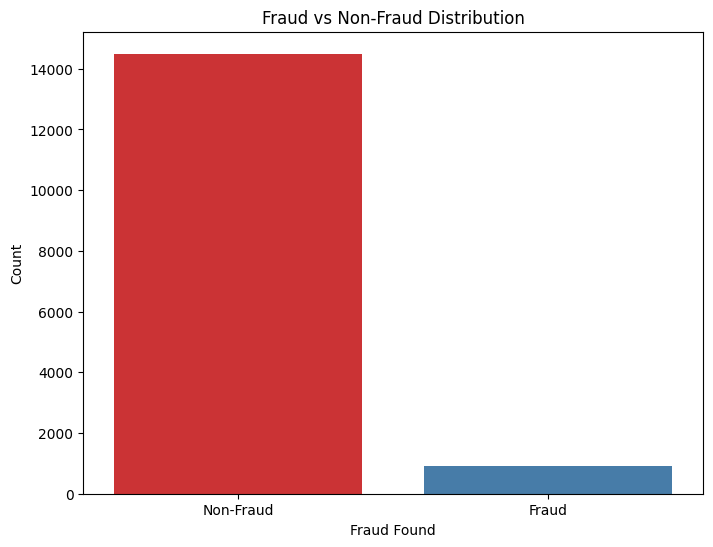

FraudFound_P
0    14496
1      923
Name: count, dtype: int64


In [106]:
fraud_vs_non_fraud = numeric_df['FraudFound_P'].value_counts()

# Plotting the bar chart
plt.figure(figsize=(8,6))
sns.countplot(x='FraudFound_P', data=numeric_df, palette='Set1')

# Customize the plot
plt.title('Fraud vs Non-Fraud Distribution')
plt.xlabel('Fraud Found')
plt.ylabel('Count')
plt.xticks([0, 1], ['Non-Fraud', 'Fraud'])

# Show the plot
plt.show()
print(fraud_vs_non_fraud)

From above, we can see that the data is very imbalanced when it comes to fraud vs non-fraud

## Dashboard of top 10 features

In [96]:
df['Age'] = numeric_df['Age']

C:\Users\teomi\AppData\Local\Temp\ipykernel_11368\1918467046.py:60: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=8)
C:\Users\teomi\AppData\Local\Temp\ipykernel_11368\1918467046.py:60: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=8)


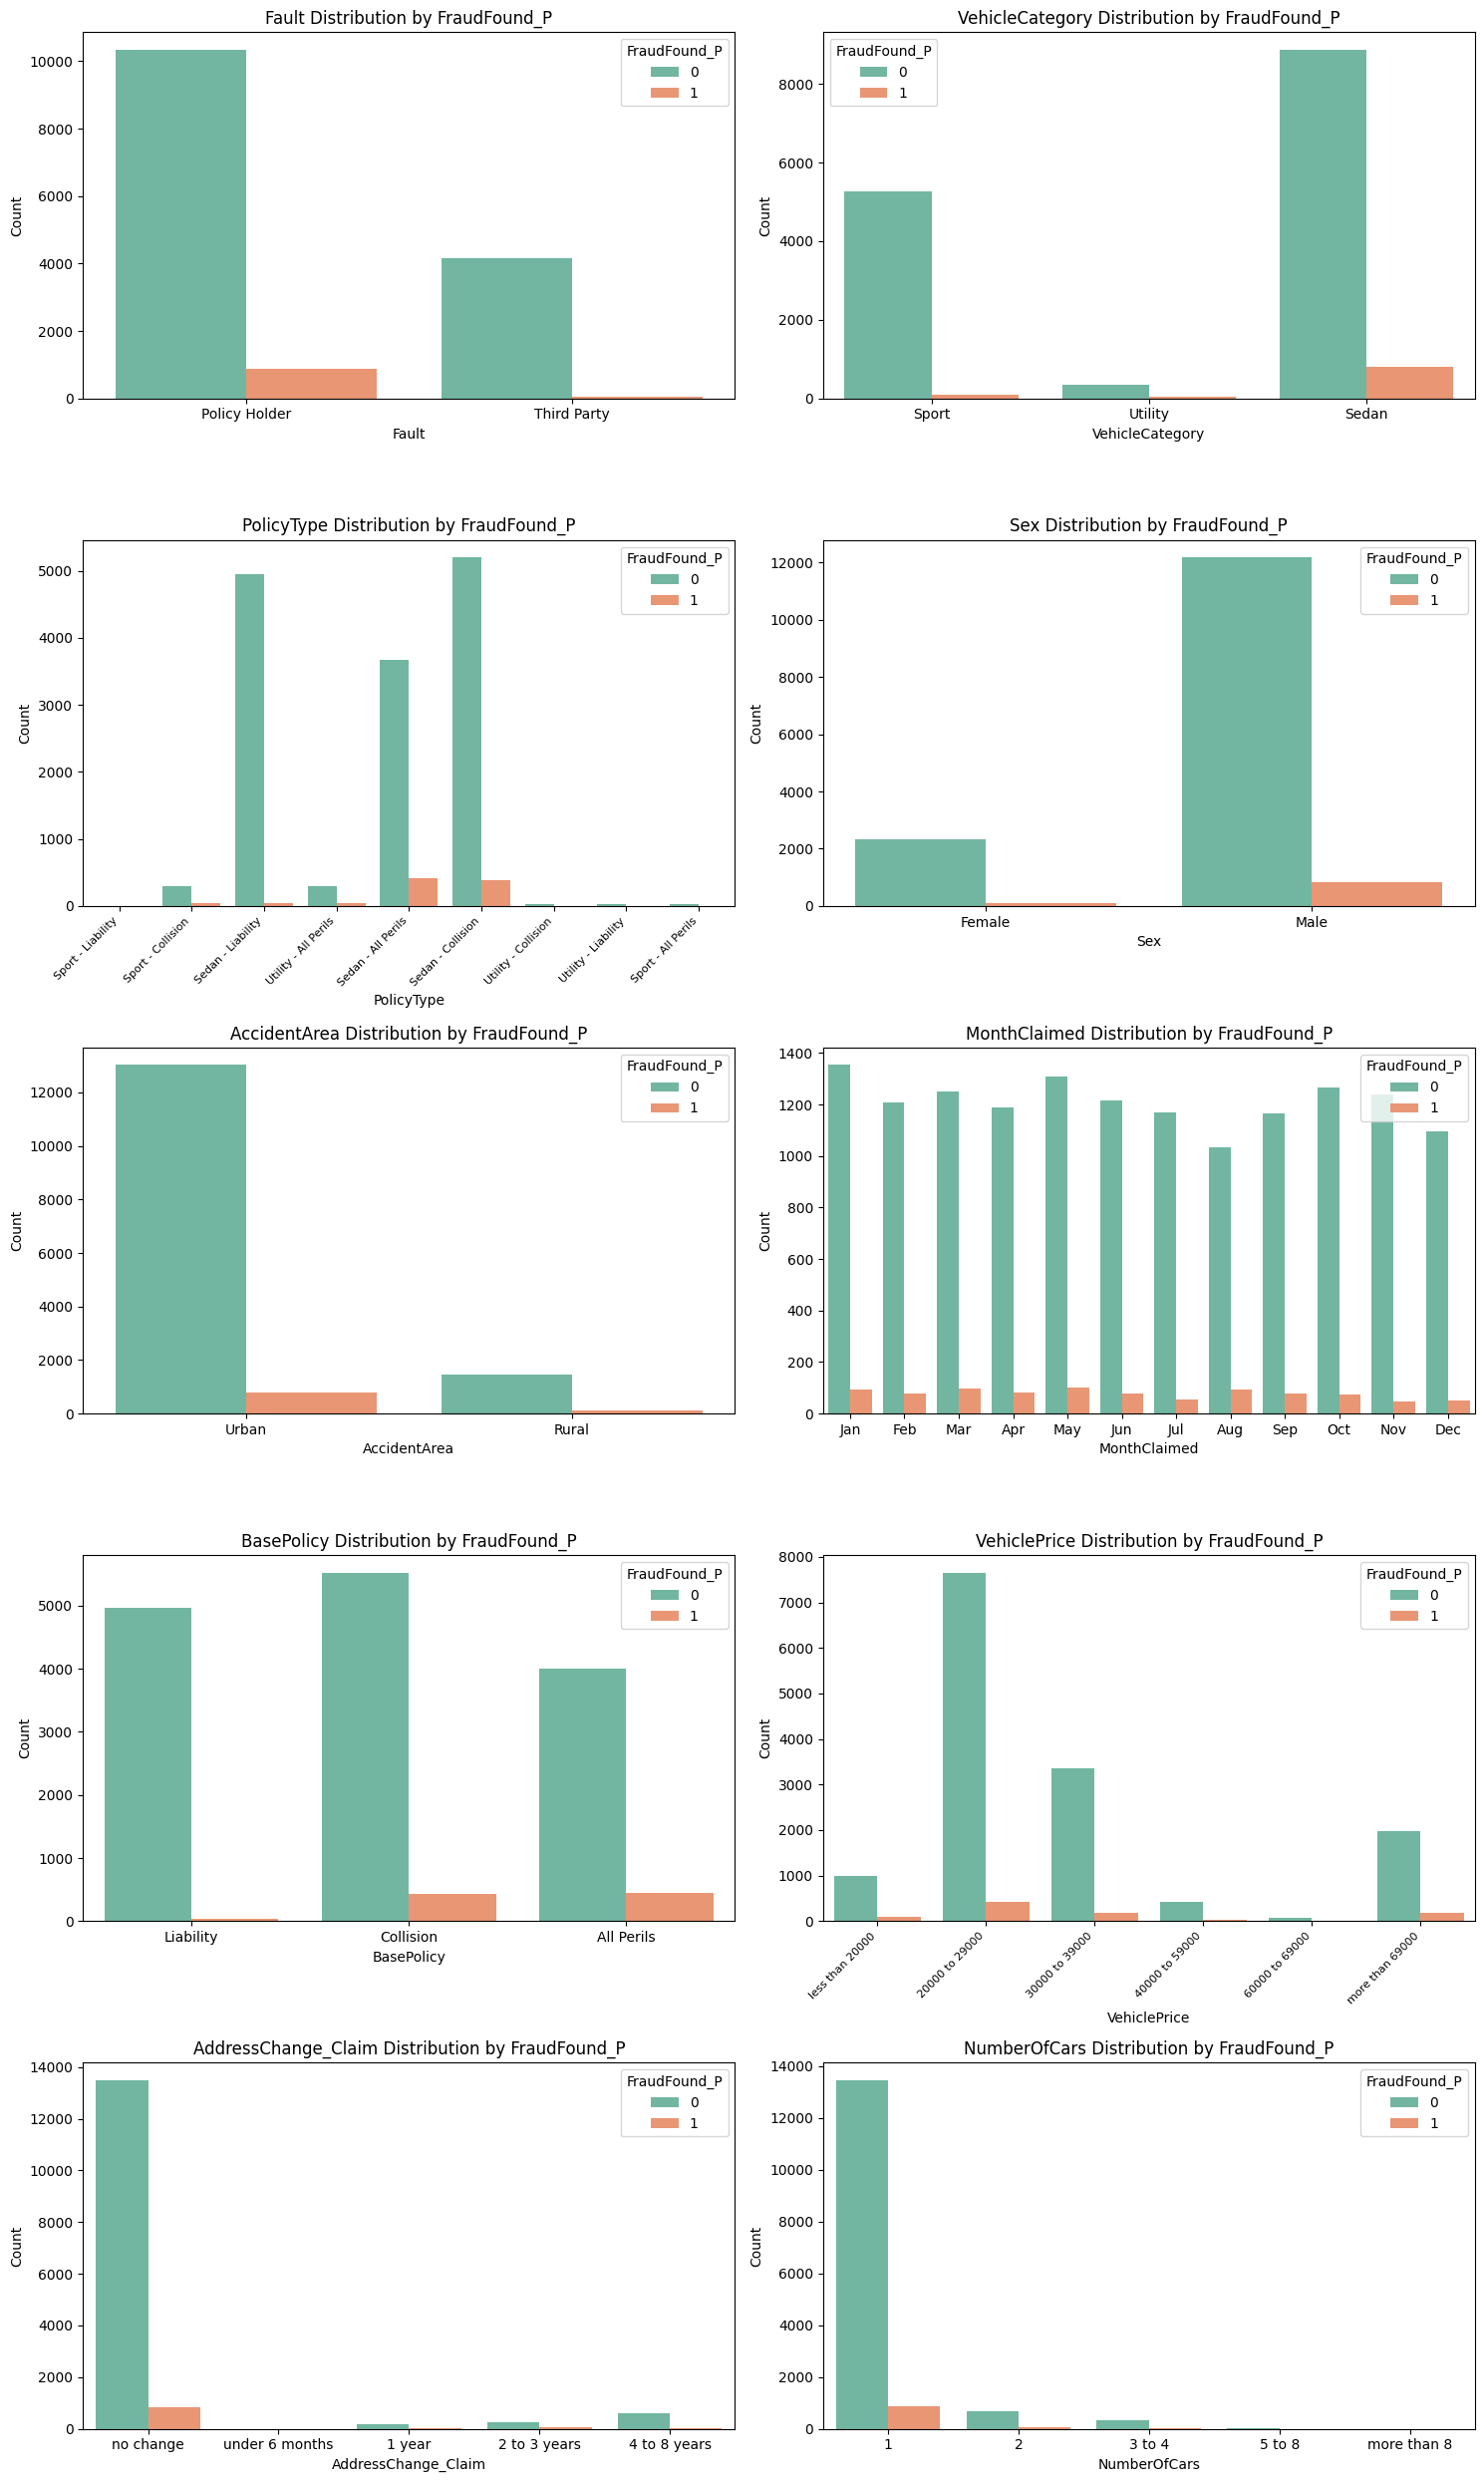

In [103]:
features = ['Fault', 'VehicleCategory', 'PolicyType', 'Sex', 'AccidentArea',
            'MonthClaimed', 'BasePolicy', 'VehiclePrice', 'AddressChange_Claim', 'NumberOfCars']

# Define mappings and orders for specific features
sex_mapping = {0: 'Female', 1: 'Male'}
sex_order = ['Female', 'Male']

month_claimed_mapping = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 
                         7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}
month_claimed_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

vehicle_price_mapping = {0: 'less than 20000', 1: '20000 to 29000', 2: '30000 to 39000', 
                         3: '40000 to 59000', 4: '60000 to 69000', 5: 'more than 69000'}
vehicle_price_order = ['less than 20000', '20000 to 29000', '30000 to 39000', 
                       '40000 to 59000', '60000 to 69000', 'more than 69000']

address_change_mapping = {0: 'no change', 1: 'under 6 months', 2: '1 year', 
                          3: '2 to 3 years', 4: '4 to 8 years'}
address_change_order = ['no change', 'under 6 months', '1 year', '2 to 3 years', '4 to 8 years']

number_of_cars_mapping = {1: '1', 2: '2', 3: '3 to 4', 
                          5: '5 to 8', 9: 'more than 8'}
number_of_cars_order = ['1', '2', '3 to 4', '5 to 8', 'more than 8']

# Create a grid of subplots (5 rows x 2 columns)
fig, axs = plt.subplots(5, 2, figsize=(15, 25))
axs = axs.flatten()

for i, feature in enumerate(features):
    ax = axs[i]
    # Create a temporary dataframe for mapping without modifying the original
    temp_df = df.copy()
    order = None # default order remains None unless specified 
    
    # Apply mapping if the feature needs to be reverted to original labels
    if feature == 'Sex':
        temp_df[feature] = temp_df[feature].replace(sex_mapping)
        order = sex_order
    elif feature == 'MonthClaimed':
        temp_df[feature] = temp_df[feature].replace(month_claimed_mapping)
        order = month_claimed_order
    elif feature == 'VehiclePrice':
        temp_df[feature] = temp_df[feature].replace(vehicle_price_mapping)
        order = vehicle_price_order
    elif feature == 'AddressChange_Claim':
        temp_df[feature] = temp_df[feature].replace(address_change_mapping)
        order = address_change_order
    elif feature == 'NumberOfCars':
        temp_df[feature] = temp_df[feature].replace(number_of_cars_mapping)
        order = number_of_cars_order
    
    # Create the countplot
    sns.countplot(x=feature, hue='FraudFound_P', data=temp_df, palette='Set2', ax=ax, order=order)
    ax.set_title(f'{feature} Distribution by FraudFound_P')
    ax.set_xlabel(feature)
    ax.set_ylabel('Count')
    
    # For PolicyType and VehiclePrice, rotate x-axis labels 45° anticlockwise and reduce font size
    if (feature == 'PolicyType' or feature == 'VehiclePrice'):
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=8)
        
plt.tight_layout()
plt.show()

# Sampling methods

### Oversampling
Use X_train_oversampled, y_train_oversampled when doing the models

In [34]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

# Prepare the data
X = numeric_df.drop(['FraudFound_P', 'PolicyNumber'], axis=1)
y = numeric_df['FraudFound_P']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)  # 80-20 split

# Define SMOTE (Synthetic Minority Over-sampling Technique)
smote = SMOTE(random_state=42)

# Apply SMOTE to the training data to oversample the minority class 
X_train_oversampled, y_train_oversampled = smote.fit_resample(X_train, y_train)

# Check the class distribution after oversampling
print("Class distribution after oversampling:")
print(pd.Series(y_train_oversampled).value_counts().to_string())




Class distribution after oversampling:
FraudFound_P
1    11611
0    11611


In [35]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lightgbm as lgb
# from imblearn.over_sampling import SMOTE

In [36]:
# Train logistic regression model
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train_oversampled, y_train_oversampled)

# Predictions
y_pred_lr = lr_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred_lr)
conf_matrix = confusion_matrix(y_test, y_pred_lr)
classification_rep = classification_report(y_test, y_pred_lr)

# Print results
print(f"Accuracy: {accuracy:.4f}")
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(classification_rep)


Accuracy: 0.7004
Confusion Matrix:
[[2081  804]
 [ 120   79]]
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.72      0.82      2885
           1       0.09      0.40      0.15       199

    accuracy                           0.70      3084
   macro avg       0.52      0.56      0.48      3084
weighted avg       0.89      0.70      0.77      3084



/Users/Student/anaconda3/envs/new_env/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [37]:
rf_model = RandomForestClassifier(n_estimators=100, class_weight="balanced", random_state=36)
rf_model.fit(X_train_oversampled, y_train_oversampled)
y_pred_rf = rf_model.predict(X_test)

# Evaluation
print("==== Random Forest ====")
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf):.4f}")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf))
print("Classification Report:")
print(classification_report(y_test, y_pred_rf))

==== Random Forest ====
Accuracy: 0.8920
Confusion Matrix:
[[2716  169]
 [ 164   35]]
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94      2885
           1       0.17      0.18      0.17       199

    accuracy                           0.89      3084
   macro avg       0.56      0.56      0.56      3084
weighted avg       0.89      0.89      0.89      3084



In [38]:
xgb_model = xgb.XGBClassifier(n_estimators=100, use_label_encoder=False, eval_metric="logloss", random_state=42)
xgb_model.fit(X_train_oversampled, y_train_oversampled)
y_pred_xgb = xgb_model.predict(X_test)

# Evaluation
print("==== XGBoost ====")
print(f"Accuracy: {accuracy_score(y_test, y_pred_xgb):.4f}")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_xgb))
print("Classification Report:")
print(classification_report(y_test, y_pred_xgb))

==== XGBoost ====
Accuracy: 0.8907
Confusion Matrix:
[[2703  182]
 [ 155   44]]
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.94      0.94      2885
           1       0.19      0.22      0.21       199

    accuracy                           0.89      3084
   macro avg       0.57      0.58      0.57      3084
weighted avg       0.90      0.89      0.89      3084



/Users/Student/anaconda3/envs/new_env/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [18:03:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [39]:
lgb_model = lgb.LGBMClassifier(n_estimators=100, random_state=42)
lgb_model.fit(X_train_oversampled, y_train_oversampled)
y_pred_lgb = lgb_model.predict(X_test)

# Evaluation
print("==== LightGBM ====")
print(f"Accuracy: {accuracy_score(y_test, y_pred_lgb):.4f}")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_lgb))
print("Classification Report:")
print(classification_report(y_test, y_pred_lgb))

==== LightGBM ====
Accuracy: 0.8609
Confusion Matrix:
[[2594  291]
 [ 138   61]]
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.90      0.92      2885
           1       0.17      0.31      0.22       199

    accuracy                           0.86      3084
   macro avg       0.56      0.60      0.57      3084
weighted avg       0.90      0.86      0.88      3084



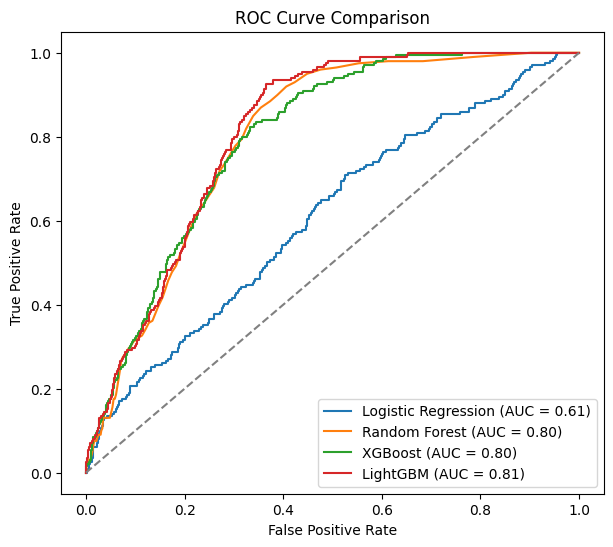

In [40]:
from sklearn.metrics import roc_curve, auc

# Function to plot ROC curve
def plot_roc_curve(y_test, y_pred_prob, model_name):
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    roc_auc = auc(fpr, tpr)
    
    plt.plot(fpr, tpr, label=f"{model_name} (AUC = {roc_auc:.2f})")
    
# Get predicted probabilities for ROC curve
y_pred_prob_lr = lr_model.predict_proba(X_test)[:, 1]
y_pred_prob_rf = rf_model.predict_proba(X_test)[:, 1]
y_pred_prob_xgb = xgb_model.predict_proba(X_test)[:, 1]
y_pred_prob_lgb = lgb_model.predict_proba(X_test)[:, 1]

# Plot ROC Curves
plt.figure(figsize=(7, 6))
plot_roc_curve(y_test, y_pred_prob_lr, "Logistic Regression")
plot_roc_curve(y_test, y_pred_prob_rf, "Random Forest")
plot_roc_curve(y_test, y_pred_prob_xgb, "XGBoost")
plot_roc_curve(y_test, y_pred_prob_lgb, "LightGBM")

# Formatting the plot
plt.plot([0, 1], [0, 1], linestyle="--", color="grey")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.show()

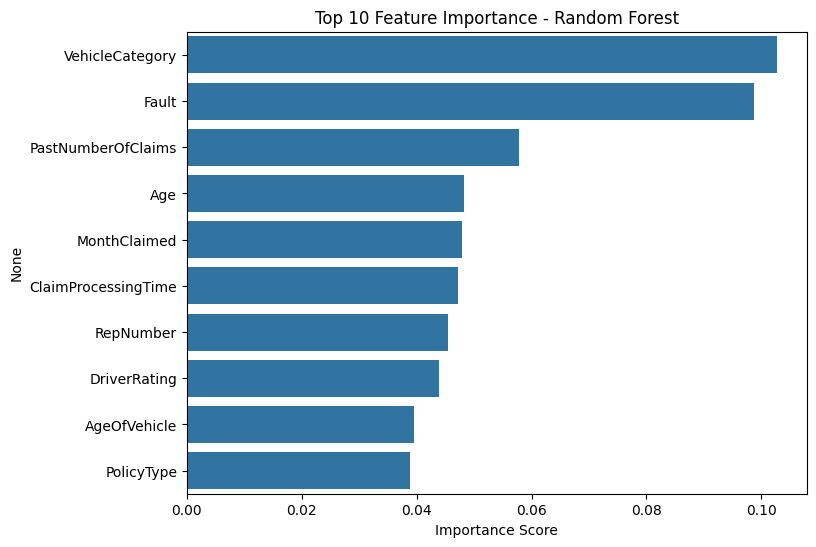

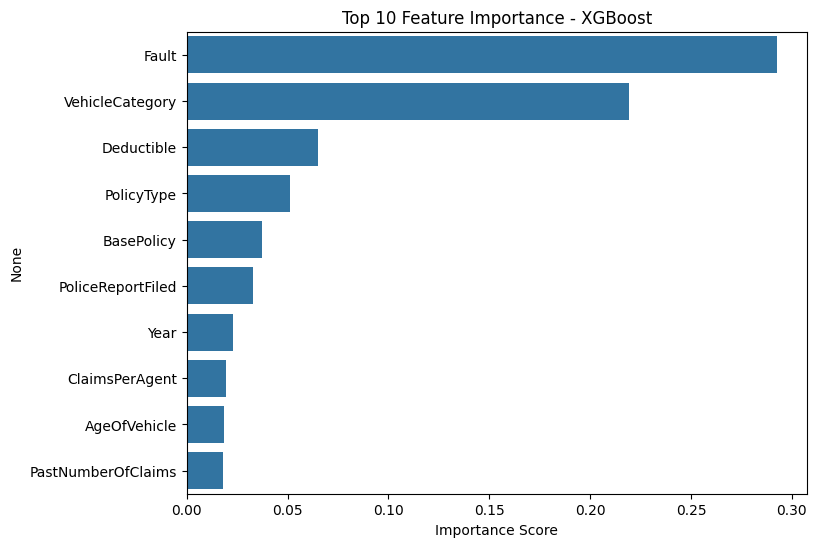

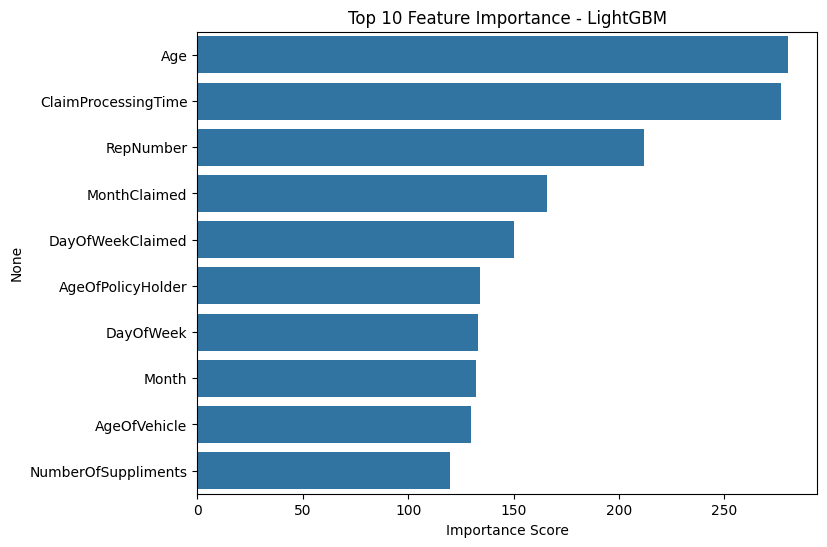

In [41]:
# Feature importance visualization for Random Forest
rf_importances = pd.Series(rf_model.feature_importances_, index=X_train.columns).sort_values(ascending=False)
plt.figure(figsize=(8, 6))
sns.barplot(x=rf_importances.values[:10], y=rf_importances.index[:10])
plt.title("Top 10 Feature Importance - Random Forest")
plt.xlabel("Importance Score")
plt.show()

# Feature importance visualization for XGBoost
xgb_importances = pd.Series(xgb_model.feature_importances_, index=X_train.columns).sort_values(ascending=False)
plt.figure(figsize=(8, 6))
sns.barplot(x=xgb_importances.values[:10], y=xgb_importances.index[:10])
plt.title("Top 10 Feature Importance - XGBoost")
plt.xlabel("Importance Score")
plt.show()

# Feature importance visualization for LightGBM
lgb_importances = pd.Series(lgb_model.feature_importances_, index=X_train.columns).sort_values(ascending=False)
plt.figure(figsize=(8, 6))
sns.barplot(x=lgb_importances.values[:10], y=lgb_importances.index[:10])
plt.title("Top 10 Feature Importance - LightGBM")
plt.xlabel("Importance Score")
plt.show()

In [42]:
from sklearn.ensemble import VotingClassifier, StackingClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [43]:
# Define base models
from sklearn.calibration import CalibratedClassifierCV

calibrated_rf = CalibratedClassifierCV(
    RandomForestClassifier(n_estimators=100, class_weight="balanced", random_state=36),
    method='isotonic', cv=3
)

voting_clf = VotingClassifier(
    estimators=[
        ('lr', make_pipeline(StandardScaler(), LogisticRegression(max_iter=2000, class_weight="balanced"))),
        ('rf', calibrated_rf),
        ('xgb', xgb.XGBClassifier(n_estimators=100, eval_metric="logloss", random_state=42, scale_pos_weight=12)),
        ('lgb', lgb.LGBMClassifier(n_estimators=100, class_weight='balanced', random_state=42))
    ],
    voting='soft'  # Change to 'hard' for majority voting
)

# Train voting classifier
voting_clf.fit(X_train_oversampled, y_train_oversampled)

# Predict
y_proba = voting_clf.predict_proba(X_test)[:, 1]
y_pred_voting = (y_proba >= 0.30).astype(int)
# Evaluate
print("==== Voting Classifier ====")
print(f"Accuracy: {accuracy_score(y_test, y_pred_voting):.4f}")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_voting))
print("Classification Report:")
print(classification_report(y_test, y_pred_voting))

==== Voting Classifier ====
Accuracy: 0.7899
Confusion Matrix:
[[2325  560]
 [  88  111]]
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.81      0.88      2885
           1       0.17      0.56      0.26       199

    accuracy                           0.79      3084
   macro avg       0.56      0.68      0.57      3084
weighted avg       0.91      0.79      0.84      3084



In [44]:
from sklearn.calibration import CalibratedClassifierCV

calibrated_rf = CalibratedClassifierCV(
    RandomForestClassifier(n_estimators=100, class_weight="balanced", random_state=36),
    method='isotonic', cv=3
)

voting_clf = VotingClassifier(
    estimators=[
        ('lr', make_pipeline(StandardScaler(), LogisticRegression(max_iter=2000, class_weight="balanced"))),
        ('rf', calibrated_rf),
        ('xgb', xgb.XGBClassifier(n_estimators=100, eval_metric="logloss", random_state=42, scale_pos_weight=12)),
        ('lgb', lgb.LGBMClassifier(n_estimators=100, class_weight='balanced', random_state=42))
    ],
    voting='soft'  # Change to 'hard' for majority voting
)

# Train voting classifier
voting_clf.fit(X_train_oversampled, y_train_oversampled)

# Predict
y_proba = voting_clf.predict_proba(X_test)[:, 1]
from sklearn.metrics import precision_recall_curve, f1_score

precisions, recalls, thresholds = precision_recall_curve(y_test, y_proba)

f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-6)
best_threshold = thresholds[f1_scores.argmax()]
print(f"Best Threshold by F1: {best_threshold:.2f}, F1-score: {f1_scores.max():.3f}")

# Use the new threshold
y_pred_best = (y_proba >= best_threshold).astype(int)
print(classification_report(y_test, y_pred_best, digits=3))

# Model Update Summary (Voting Classifier)

# - Applied class balancing techniques: 'class_weight' and 'scale_pos_weight' for base models
# - Calibrated the Random Forest classifier using isotonic regression for better probability estimates
# - Used 'soft' voting to average predicted probabilities across models
# - Tuned the classification threshold using precision-recall curve to optimize for F1-score of fraud class (label=1)
# ➤ These changes aim to improve fraud detection performance, especially recall and F1, on the imbalanced test set

Best Threshold by F1: 0.29, F1-score: 0.262
              precision    recall  f1-score   support

           0      0.966     0.800     0.875      2885
           1      0.169     0.588     0.262       199

    accuracy                          0.787      3084
   macro avg      0.567     0.694     0.569      3084
weighted avg      0.914     0.787     0.836      3084



In [45]:
# Imports
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import make_scorer, f1_score
import xgboost as xgb
import lightgbm as lgb
import numpy as np

# Logistic Regression with StandardScaler
lr_model = make_pipeline(
    StandardScaler(),
    LogisticRegression(max_iter=2000, class_weight='balanced', random_state=42)
)

# Random Forest
rf_model = RandomForestClassifier(class_weight='balanced', random_state=42)

# XGBoost with imbalance handling
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', scale_pos_weight=12, random_state=42)

# LightGBM
lgb_model = lgb.LGBMClassifier(class_weight='balanced', random_state=42)

voting_clf = VotingClassifier(
    estimators=[
        ('lr', lr_model),
        ('rf', rf_model),
        ('xgb', xgb_model),
        ('lgb', lgb_model)
    ],
    voting='soft'
)

pipeline = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('voting', voting_clf)
])

param_dist = {
    'voting__rf__n_estimators': [100, 200, 300],
    'voting__rf__max_depth': [5, 10, None],
    'voting__xgb__learning_rate': [0.01, 0.1, 0.2],
    'voting__xgb__n_estimators': [100, 200],
    'voting__lgb__n_estimators': [100, 200],
    'voting__lgb__learning_rate': [0.01, 0.1]
}

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scorer = make_scorer(f1_score, pos_label=1)

random_search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_dist,
    n_iter=10,
    scoring=scorer,
    cv=skf,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# Fit on training data
random_search.fit(X_train, y_train)

# Best model results
print("Best F1-score (fraud class):", random_search.best_score_)
print("Best parameters:")
print(random_search.best_params_)

from sklearn.metrics import classification_report, confusion_matrix

y_pred_best = random_search.predict(X_test)
print(confusion_matrix(y_test, y_pred_best))
print(classification_report(y_test, y_pred_best, digits=3))

Fitting 5 folds for each of 10 candidates, totalling 50 fits


/Users/Student/anaconda3/envs/new_env/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [18:04:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/Student/anaconda3/envs/new_env/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [18:04:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/Student/anaconda3/envs/new_env/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [18:04:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/Student/anaconda3/envs/new_env/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [18:04:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.

Best F1-score (fraud class): 0.25017554149923477
Best parameters:
{'voting__xgb__n_estimators': 200, 'voting__xgb__learning_rate': 0.01, 'voting__rf__n_estimators': 200, 'voting__rf__max_depth': None, 'voting__lgb__n_estimators': 200, 'voting__lgb__learning_rate': 0.1}
[[2396  489]
 [ 103   96]]
              precision    recall  f1-score   support

           0      0.959     0.831     0.890      2885
           1      0.164     0.482     0.245       199

    accuracy                          0.808      3084
   macro avg      0.561     0.656     0.567      3084
weighted avg      0.908     0.808     0.848      3084



In [46]:
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_curve
import xgboost as xgb
import lightgbm as lgb
import numpy as np

# Base models with class weightings
base_models = [
    ('lr', make_pipeline(StandardScaler(), LogisticRegression(max_iter=2000, class_weight="balanced"))),
    ('rf', RandomForestClassifier(n_estimators=100, class_weight="balanced", random_state=36)),
    ('xgb', xgb.XGBClassifier(n_estimators=100, eval_metric="logloss", random_state=42, scale_pos_weight=12)),
    ('lgb', lgb.LGBMClassifier(n_estimators=100, class_weight='balanced', random_state=42))
]

# Stronger meta model
meta_model = RandomForestClassifier(n_estimators=100, class_weight="balanced", random_state=42)

# Stacking classifier (no oversampled data used here!)
stack_clf = StackingClassifier(
    estimators=base_models,
    final_estimator=meta_model,
    cv=5,
    passthrough=True,
    n_jobs=-1
)

# Full pipeline with SMOTE
pipeline = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('stacking', stack_clf)
])

# StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Cross-validated predictions on training data (simulate test set)
y_proba_cv = cross_val_predict(pipeline, X_train, y_train, cv=skf, method='predict_proba', n_jobs=-1)[:, 1]

# Find best threshold
precisions, recalls, thresholds = precision_recall_curve(y_train, y_proba_cv)
f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-6)
best_threshold = thresholds[f1_scores.argmax()]
print(f"Best Threshold by F1: {best_threshold:.2f}, F1-score: {f1_scores.max():.3f}")

# Refit final model on full training data
pipeline.fit(X_train, y_train)

# Predict on real test set
y_proba_test = pipeline.predict_proba(X_test)[:, 1]
y_pred_test = (y_proba_test >= best_threshold).astype(int)

# Evaluation
print("==== Final Stacking Classifier with CV + SMOTE ====")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_test))
print("Classification Report:")
print(classification_report(y_test, y_pred_test, digits=3))

# Model Update Summary (Stacking Classifier)
# - Replaced training on oversampled data with StratifiedKFold cross-validation
# - Applied SMOTE inside each fold using a pipeline to avoid data leakage
# - Used a stronger meta-model (Random Forest instead of Logistic Regression)
# - Tuned the decision threshold based on the best F1-score from precision-recall curve
# These changes aim to improve fraud class (label=1) recall and F1-score while keeping evaluation realistic

[LightGBM] [Info] Number of positive: 9289, number of negative: 9289
[LightGBM] [Info] Number of positive: 9289, number of negative: 9289
[LightGBM] [Info] Number of positive: 9289, number of negative: 9289
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.091507 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 552
[LightGBM] [Info] Number of data points in the train set: 18578, number of used features: 34
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.038768 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 552
[LightGBM] [Info] Number of data points in the train set: 18578, number of used features: 34
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM]

### Undersampling

With a combined of around 15000 fraud and non-fraud cases, undersampling would reduce a significant amount of data (13000 cases), which can lead to loss of important information from the majority class that potentially holds valuable patterns that can help the model generalize better.

For fraud detection, it is typically better to use techniques that preserve data while addressing class imbalance hence we shall not proceed in depth with undersampled data.

In [47]:
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import pandas as pd

# Assuming numeric_df is your dataset (already loaded)
# Prepare the data
X = numeric_df.drop(['FraudFound_P', 'PolicyNumber'], axis=1)
y = numeric_df['FraudFound_P']

# Split the data into training and testing sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define RandomUnderSampler
under_sampler = RandomUnderSampler(random_state=42)

# Apply RandomUnderSampler to the training data to reduce the majority class size
X_train_under, y_train_under = under_sampler.fit_resample(X_train, y_train)

# Check the class distribution after undersampling
print("Class distribution after undersampling:")
print(pd.Series(y_train_under).value_counts())

# Train and evaluate a RandomForest model on the original dataset (without undersampling)
clf_original = RandomForestClassifier(random_state=42)
clf_original.fit(X_train, y_train)
y_pred_original = clf_original.predict(X_test)

# Train and evaluate a RandomForest model on the undersampled dataset
clf_under = RandomForestClassifier(random_state=42)
clf_under.fit(X_train_under, y_train_under)
y_pred_under = clf_under.predict(X_test)

print("\nPerformance on undersampled dataset:")
print(classification_report(y_test, y_pred_under, zero_division=0))








Class distribution after undersampling:
FraudFound_P
0    724
1    724
Name: count, dtype: int64

Performance on undersampled dataset:
              precision    recall  f1-score   support

           0       0.99      0.64      0.78      2885
           1       0.15      0.90      0.26       199

    accuracy                           0.66      3084
   macro avg       0.57      0.77      0.52      3084
weighted avg       0.94      0.66      0.75      3084



From the result above, we can see that the precision and f1-score of the undersampled data is very low. While the model has high recall, it is returning many false positives as its precision is not there. Thus, it shows that the model is just classfying everything as fraud as it does not have have enough data to learn from.